<H1> CLTV Prediction </H1>

We are going to build simple machine learning models that predicts our customers lifetime value and compare their performances.

In [47]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_fscore_support,accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

<a name=1> <h1> 1. Feature Engineering </h2></a>

In [48]:
# get the data
import pickle

with open("tx_cluster.pkl", "rb") as f:
    tx_cluster = pickle.load(f)

tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.00,0
1,17602.0,1,3,565,1,5050.77,1,5,High-Value,128.75,0
2,17509.0,57,2,369,1,6100.74,1,4,Mid-Value,0.00,0
3,13093.0,266,0,170,0,7741.47,1,1,Low-Value,262.55,0
4,17809.0,15,3,64,0,4627.62,1,4,Mid-Value,276.72,0


In [49]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster) #There is only one categorical variable segment
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,1,2,0.00,0,False,True,False
1,17602.0,1,3,565,1,5050.77,1,5,128.75,0,True,False,False
2,17509.0,57,2,369,1,6100.74,1,4,0.00,0,False,False,True
3,13093.0,266,0,170,0,7741.47,1,1,262.55,0,False,True,False
4,17809.0,15,3,64,0,4627.62,1,4,276.72,0,False,False,True


In [50]:
tx_class.describe()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster
count,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000
mean,15561.356010,91.613811,2.098977,84.348849,0.113555,1289.904252,0.057545,2.270077,513.677960,0.221995
std,1575.088247,100.383464,1.055228,152.686136,0.332276,2117.764962,0.235097,1.273618,873.629228,0.483366
min,12346.000000,0.000000,0.000000,1.000000,0.000000,-4287.630000,0.000000,0.000000,-4287.630000,0.000000
25%,14209.250000,16.000000,1.000000,16.250000,0.000000,279.230000,0.000000,1.000000,0.000000,0.000000
50%,15569.500000,49.000000,2.000000,40.000000,0.000000,618.040000,0.000000,2.000000,205.305000,0.000000
75%,16911.500000,144.000000,3.000000,98.000000,0.000000,1483.497500,0.000000,3.000000,626.360000,0.000000
max,18287.000000,373.000000,3.000000,5128.000000,3.000000,57120.910000,2.000000,8.000000,7387.220000,2.000000


In [51]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.890176
Revenue               0.673601
RevenueCluster        0.603433
Segment_High-Value    0.511627
FrequencyCluster      0.470566
Frequency             0.447167
OverallScore          0.419524
RecencyCluster        0.223734
Segment_Mid-Value     0.037707
CustomerID           -0.044819
Recency              -0.224075
Segment_Low-Value    -0.234132
Name: LTVCluster, dtype: float64

We see that Revenue, Frequency and RFM scores will be helpful for our machine learning models from the correlation with LTVCluster.

In [52]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

<a href=2> <h1> 2. Models </h1></a>

Since our LTV Clusters are 3 types, high LTV, mid LTV and low LTV; we will perform multi class classification.

<a href=2.1> <h2> 2.1 Logistic Regression </h2></a>

In [53]:
from sklearn.linear_model import LogisticRegression

basemodelname = "Logit_test"
params = {
    "penalty": None,
    "class_weight": 'balanced'}
parsuf = '_'.join([key.replace('_','')+str(val).replace('.','') for key,val in params.items()])
modelname=f"{basemodelname}_{parsuf}"

ltv_logreg = LogisticRegression(
    penalty=params['penalty'],
    class_weight=params['class_weight'],
    max_iter=1000
).fit(X_train, y_train)

acc_train = ltv_logreg.score(X_train, y_train)
acc_test = ltv_logreg.score(X_test[X_train.columns], y_test)

print(f"Modelname: {modelname}")
print('Accuracy of Logit classifier on training set: {:.2f}'.format(acc_train))
print('Accuracy of Logit classifier on test set: {:.2f}'.format(acc_test))

y_pred = ltv_logreg.predict(X_test)
clfreport = classification_report(y_test, y_pred)
print(clfreport)

Modelname: Logit_test_penaltyNone_classweightbalanced
Accuracy of Logit classifier on training set: 0.87
Accuracy of Logit classifier on test set: 0.86
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       156
           1       0.59      0.74      0.66        35
           2       0.62      1.00      0.77         5

    accuracy                           0.86       196
   macro avg       0.72      0.88      0.78       196
weighted avg       0.88      0.86      0.87       196



<a href=2.2> <h2> 2.2 XGBoost </h2></a>

In [54]:
import xgboost as xgb

basemodelname = "xgboost_test"
params = {
        "max_depth": 5,
        "learning_rate":0.1}
parsuf = '_'.join([key.replace('_','')+str(val).replace('.','') for key,val in params.items()])
modelname=f"{basemodelname}_{parsuf}"

ltv_xgb = xgb.XGBClassifier(
    max_depth=params['max_depth'], 
    learning_rate=params['learning_rate'],
    n_jobs=-1
).fit(X_train, y_train)

print(f"Modelname: {modelname}")
acc_train = ltv_xgb.score(X_train, y_train)
acc_test = ltv_xgb.score(X_test[X_train.columns], y_test)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(acc_train))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(acc_test))

y_pred = ltv_xgb.predict(X_test)
clfreport = classification_report(y_test, y_pred)

Modelname: xgboost_test_maxdepth5_learningrate01
Accuracy of XGB classifier on training set: 0.96
Accuracy of XGB classifier on test set: 0.88


In [55]:
print(clfreport)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       156
           1       0.67      0.69      0.68        35
           2       0.67      0.40      0.50         5

    accuracy                           0.88       196
   macro avg       0.76      0.68      0.71       196
weighted avg       0.88      0.88      0.88       196



In [56]:
import numpy as np
from mlxtend.evaluate import lift_score

y_target =    np.array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0])
y_predicted = np.array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0])
positive_label = '2'

ls = lift_score(y_target, y_predicted, binary=False, positive_label=positive_label)
print(ls)

1.6666666666666667


In [57]:
print('hello')

hello


In [58]:
def calculate_lift(y_val, y_pred, step=10):
    #Create auxiliary dataframe to store the real value and predicted probabilities
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    
    #Drop missing observations with no value
    aux_lift = aux_lift.loc[aux_lift['predicted'].notnull()]
    # drop customers where score is over highest non-customer
    max_de = aux_lift["predicted"].where(aux_lift["real"] == 0).max()
    aux_lift.drop(aux_lift.index[aux_lift['predicted'] > max_de], inplace=True)
    aux_lift.reset_index()
    #Rank the scored file, in descending order by estimated probability 
    aux_lift = aux_lift.sort_values(by='predicted', ascending=False)

    #Split the ranked file into deciles (step is the number of scorecards to be used)
    aux_lift['percentile'] = pd.qcut(aux_lift['predicted'].where(aux_lift['real'] == 0).rank(method='first'), q=step, labels=False)
    #get the minimum predicted values of real 0 per quantile
    percentile_limits = aux_lift.groupby(['percentile']).min().predicted
    percentile_limits = percentile_limits.to_dict()
    #put real 1s in the equivalent score class based on their minimum value
    for quantil, min_score in percentile_limits.items():
        aux_lift.loc[aux_lift.predicted > min_score, 'percentile'] = quantil
    
    #turn the scores so that 1 is the best scoreclass
    aux_lift['percentile'] = step - aux_lift['percentile']

    #Overal response rate (threshold)
    total_num_customers = len(aux_lift)
    total_responses = aux_lift.real.value_counts()[1]
    response_rate = total_responses/total_num_customers*100
    
    #Create final dataframe to store the lift and gain scores
    lift = pd.DataFrame()
    
    #Observations in each percentile
    lift['num_customers'] = (aux_lift.groupby('percentile').size()).astype(int)
    lift['cum_customers'] = np.cumsum(lift['num_customers'])
    lift['cum_pct_customers'] = ((lift['cum_customers']/total_num_customers)*100).round(2)

    #Response rate in each percentile
    lift['num_responses'] = (aux_lift.groupby('percentile')['real'].sum()).astype(int)
    lift['response_rate'] = ((lift['num_responses']/lift['num_customers'])*100).round(2)
    lift['cum_responses'] = np.cumsum(lift['num_responses'])

    #Cumulative gain
    lift['pct_gain'] = ((lift['num_responses']/total_responses)*100).round(2)
    lift['cum_gain'] = ((lift['cum_responses']/total_responses)*100).round(2) #also known as cummulative gain
    #Lift score
    lift['lift'] = (lift['pct_gain'] / lift['pct_gain'].mean()).round(2)
    
    #Cumulative lift score
    lift['cum_lift'] = ((lift['cum_gain']/lift.index)/ lift['pct_gain'].mean()).round(2)
    
    return lift

In [59]:
y_target =    np.array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0])
y_predicted = np.array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0])
calculate_lift(y_target, y_predicted)

,num_customers,cum_customers,cum_pct_customers,num_responses,response_rate,cum_responses,pct_gain,cum_gain,lift,cum_lift
percentile,,,,,,,,,,
3.0,4,4,40.0,2,50.0,2,50.0,50.0,5.0,1.67
5.0,1,5,50.0,0,0.0,2,0.0,50.0,0.0,1.00
7.0,1,6,60.0,0,0.0,2,0.0,50.0,0.0,0.71
9.0,1,7,70.0,0,0.0,2,0.0,50.0,0.0,0.56
10.0,1,8,80.0,0,0.0,2,0.0,50.0,0.0,0.50


In [60]:
# --------------------------------
# Function to plot lift curve
# @Params:
# y_val: real labels of the data
# y_pred: probability predictions for such data
# step: how big we want the steps in the percentiles to be
# --------------------------------
def plot_lift_curve(y_val, y_pred, step=10):
    #Calculate lift & cumulative lift score
    lift = calculate_lift(y_val, y_pred, step)
    
    #Cumulative  lift curve
    values = lift['cum_lift'].round(2)
    x = list(range(1, len(values)+1))
    
    sample_size = lift['num_customers'].sum()
    sample_size = "\nSample size={:0.0f}".format(sample_size)
    
    fig, ax = plt.subplots()
    ax.plot(x, values, c='orange', linewidth=2)
    ax.plot(x, lift['lift'], c='gray', linewidth=2)
    ax.axhline(lift['lift'].mean(), linewidth=2, color='k', linestyle='--')
    ax.set_xticks(list(range(1, len(values)+1)))
    ax.set_xlabel('Proportion of sample\n'+sample_size) 
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    # plt.savefig('lift_curve_'+y_val.name[-2:]+'.png', dpi=300, bbox_inches='tight')
    plt.show()

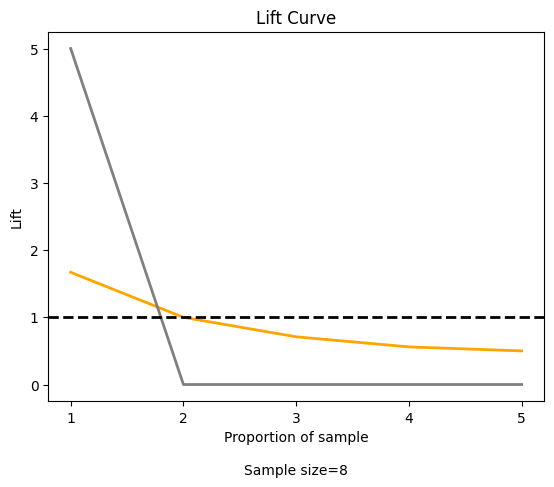

In [61]:
plot_lift_curve(y_target, y_predicted)

In [62]:
# Function that plots a Lift Curve using the real label values of a dataset and the probability predictions of a Machine Learning Algorithm/model
# @Params:
# y_val: real labels of the data
# y_pred: probability predictions for such data
# step: how big we want the steps in the percentiles to be

def plot_Lift_curve(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

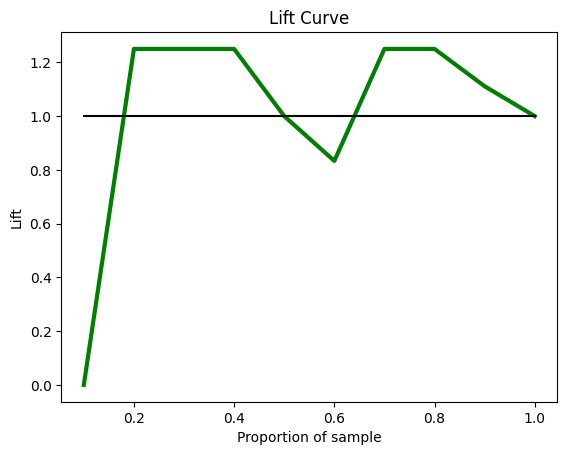

In [63]:
plot_Lift_curve(y_target, y_predicted, step=0.1)

In [67]:
import scikitplot as skplt

# y_pred = ltv_logreg.predict_proba(X_test)
# y_probas = print(y_pred)

skplt.metrics.plot_lift_curve(y_test, y_probas)


ValueError: Cannot calculate Lift Curve for data with 3 category/ies